In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
import pandas as pd
import re
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from dynamical_models import compute_VAR

# Load Data

In [2]:
dt = 0.01
subject_id = 'SC4001'
# subject_id = 'SC4401'
# subject_id = 'SC4591'
# subject_id = 'ST7011'

all_data_dir = os.path.join("/om/user/eisenaj/datasets/sleep/sleep-edf-database")

In [3]:
if subject_id[1] == 'C':
    data_folder = os.path.join(all_data_dir, 'sleep-cassette')
else: # subject_id[1] == 'T'
    data_folder = os.path.join(all_data_dir, 'sleep-telemetry')

eeg_regex = re.compile(f"{subject_id}" + ".{2}-PSG.edf")
hypnogram_regex = re.compile(f"{subject_id}" + ".{2}-Hypnogram.edf")

eeg_path = None
hypnogram_path = None
for file_name in os.listdir(data_folder):
    if eeg_regex.match(file_name):
        eeg_path = os.path.join(data_folder, file_name)
    elif hypnogram_regex.match(file_name):
        hypnogram_path = os.path.join(data_folder, file_name)

if eeg_path is None or hypnogram_path is None:
    print(f"Failed to find data for subject ID {subject_id}")

eeg = mne.io.read_raw_edf(eeg_path)
eeg_df = eeg.to_data_frame()
hypnogram = mne.read_annotations(hypnogram_path)
hypnogram_df = hypnogram.to_data_frame()

Extracting EDF parameters from /om/user/eisenaj/datasets/sleep/sleep-edf-database/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
start_time = 0
hypnogram_df['sleep_stage'] = [None]*len(hypnogram_df)
hypnogram_df['start_time'] = [None]*len(hypnogram_df)
hypnogram_df['end_time'] = [None]*len(hypnogram_df)
for i, row in hypnogram_df.iterrows():
    hypnogram_df.loc[i, 'sleep_stage'] = row.description[-1]
    hypnogram_df.loc[i, 'start_time'] = start_time
    hypnogram_df.loc[i, 'end_time'] = start_time + row.duration
    start_time += row.duration

In [5]:
eeg_df['sleep_stage'] = [None]*len(eeg_df)
place_in_session = 0
for i, row in tqdm(hypnogram_df.iterrows(), total=len(hypnogram_df)):
    if i == 0:
        indices = eeg_df.time <= place_in_session + int(row.duration/0.001)
    else:
        indices = np.logical_and(eeg_df.time > place_in_session, eeg_df.time <= place_in_session + int(row.duration/0.001))
    eeg_df.loc[indices, 'sleep_stage'] = row.description[-1]
    place_in_session += int(row.duration/0.001)

  0%|          | 0/154 [00:00<?, ?it/s]

## Window Selection

In [6]:
all_eeg = np.zeros((len(eeg_df), 2))
all_eeg[:, 0] = eeg_df['EEG Fpz-Cz']
all_eeg[:, 1] = eeg_df['EEG Pz-Oz']

In [7]:
VAR_results = {}
# windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.5, 0.5)]
windows = [0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

In [8]:
for window in windows:
    print(f"now computing window = {window}")
    stride = window

    num_windows = int(np.floor((all_eeg.shape[0]-int(window/dt))/int(stride/dt))+1)

    all_results = []
    for i in tqdm(range(num_windows)):
        start_ind = int(i*stride/dt)
        end_ind = int((i*stride + window)/dt)
        window_data = all_eeg[start_ind:end_ind]

        try:
            results = compute_VAR(window_data)
            results['start_time'] = i*stride
            results['start_time_ms'] = i*stride*1000
            results['start_ind'] = start_ind
            results['end_time'] = i*stride + window
            results['end_time_ms'] = (i*stride + window)*1000
            results['end_ind'] = end_ind
            all_results.append(results)
        except:
            pass
            # sometimes this doesn't work because the EEG isn't aligned at the beginning/end
    VAR_results[window] = pd.DataFrame(all_results)

now computing window = 0.2


  0%|          | 0/397500 [00:00<?, ?it/s]

now computing window = 0.3


  0%|          | 0/265000 [00:00<?, ?it/s]

now computing window = 0.4


  0%|          | 0/198750 [00:00<?, ?it/s]

now computing window = 0.5


  0%|          | 0/159000 [00:00<?, ?it/s]

now computing window = 1


  0%|          | 0/79500 [00:00<?, ?it/s]

now computing window = 1.5


  0%|          | 0/53000 [00:00<?, ?it/s]

now computing window = 2


  0%|          | 0/39750 [00:00<?, ?it/s]

now computing window = 2.5


  0%|          | 0/31800 [00:00<?, ?it/s]

now computing window = 3


  0%|          | 0/26500 [00:00<?, ?it/s]

now computing window = 3.5


  0%|          | 0/22714 [00:00<?, ?it/s]

now computing window = 4


  0%|          | 0/19875 [00:00<?, ?it/s]

now computing window = 4.5


  0%|          | 0/17666 [00:00<?, ?it/s]

now computing window = 5


  0%|          | 0/15900 [00:00<?, ?it/s]

now computing window = 6


  0%|          | 0/13250 [00:00<?, ?it/s]

now computing window = 6.5


  0%|          | 0/12230 [00:00<?, ?it/s]

now computing window = 7


  0%|          | 0/11357 [00:00<?, ?it/s]

now computing window = 7.5


  0%|          | 0/10600 [00:00<?, ?it/s]

now computing window = 8


  0%|          | 0/9937 [00:00<?, ?it/s]

now computing window = 8.5


  0%|          | 0/9352 [00:00<?, ?it/s]

now computing window = 9


  0%|          | 0/8833 [00:00<?, ?it/s]

now computing window = 9.5


  0%|          | 0/8368 [00:00<?, ?it/s]

now computing window = 10


  0%|          | 0/7950 [00:00<?, ?it/s]

In [9]:
T_pred = 10

predictions = {}
true_vals = {}
step_mse = {}

In [11]:
for window in windows:
    stride = window
    print(f"Now computing window = {window}")
    predictions[window] = np.zeros((len(VAR_results[window]) - 1, T_pred, all_eeg.shape[1]))
    true_vals[window] = np.zeros(predictions[window].shape)

    for i in tqdm(range(predictions[window].shape[0])):
        row = VAR_results[window].iloc[i]
        start_step = int(stride*i/dt)
#         x0 = all_eeg[start_step + int(window/dt) - 1]

        for t in range(T_pred):
            predictions[window][i, t] = np.hstack([[1], all_eeg[start_step + int(window/dt) - 1 + t]]) @ row.A_mat_with_bias
#             if t == 0:
#                 predictions[window][i, t] = np.hstack([[1], x0]) @ row.A_mat_with_bias
#             else:
#                 predictions[window][i, t] = np.hstack([[1], predictions[window][i, t - 1]]) @ row.A_mat_with_bias

        true_vals[window][i] = all_eeg[start_step + int(window/dt):start_step + int(window/dt) + T_pred]

    step_mse[window] = ((predictions[window] - true_vals[window])**2).mean(axis=2)

Now computing window = 0.2


  0%|          | 0/397499 [00:00<?, ?it/s]

Now computing window = 0.3


  0%|          | 0/264999 [00:00<?, ?it/s]

Now computing window = 0.4


  0%|          | 0/198749 [00:00<?, ?it/s]

Now computing window = 0.5


  0%|          | 0/158999 [00:00<?, ?it/s]

Now computing window = 1


  0%|          | 0/79499 [00:00<?, ?it/s]

Now computing window = 1.5


  0%|          | 0/52999 [00:00<?, ?it/s]

Now computing window = 2


  0%|          | 0/39749 [00:00<?, ?it/s]

Now computing window = 2.5


  0%|          | 0/31799 [00:00<?, ?it/s]

Now computing window = 3


  0%|          | 0/26499 [00:00<?, ?it/s]

Now computing window = 3.5


  0%|          | 0/22713 [00:00<?, ?it/s]

Now computing window = 4


  0%|          | 0/19874 [00:00<?, ?it/s]

Now computing window = 4.5


  0%|          | 0/17665 [00:00<?, ?it/s]

Now computing window = 5


  0%|          | 0/15899 [00:00<?, ?it/s]

Now computing window = 6


  0%|          | 0/13249 [00:00<?, ?it/s]

Now computing window = 6.5


  0%|          | 0/12229 [00:00<?, ?it/s]

Now computing window = 7


  0%|          | 0/11356 [00:00<?, ?it/s]

Now computing window = 7.5


  0%|          | 0/10599 [00:00<?, ?it/s]

Now computing window = 8


  0%|          | 0/9936 [00:00<?, ?it/s]

Now computing window = 8.5


  0%|          | 0/9351 [00:00<?, ?it/s]

Now computing window = 9


  0%|          | 0/8832 [00:00<?, ?it/s]

Now computing window = 9.5


  0%|          | 0/8367 [00:00<?, ?it/s]

Now computing window = 10


  0%|          | 0/7949 [00:00<?, ?it/s]

In [12]:
window_mses = [step_mse[window][:].mean() for window in windows]

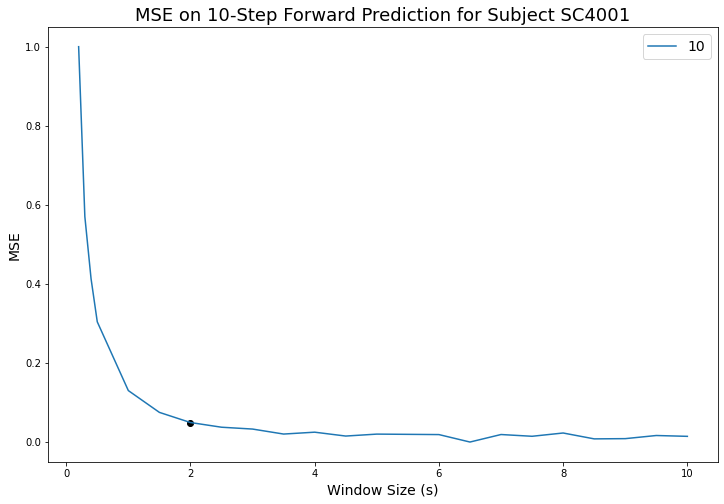

In [19]:
selected_windows = {}
plt.figure(figsize=(12, 8))
pred_steps = 10
pct_of_value = 0.95
window_mses = [step_mse[window][:].mean() for window in windows]
    
asymptotic_value = np.array(window_mses).min()
asymptotic_ind = np.argmin(window_mses)
for i in range(len(window_mses)):
    if window_mses[i]*pct_of_value <= asymptotic_value or i == asymptotic_ind:
        selected_windows = windows[i]
        break

#     plt.plot(windows, window_mses, label=area)
#     plt.plot(selected_windows)
    
#     ax = axs[int(i/2), i % 2]
mse_per_window = np.array([step_mse[window][:].mean() for window in windows])
min_val = mse_per_window.min()
max_val = mse_per_window.max()
mse_per_window -= min_val
mse_per_window /= max_val - min_val
plt.plot(windows, mse_per_window, label=area)
pt = step_mse[selected_windows][:].mean()
pt -= min_val
pt /= max_val - min_val
#         if num == 2 and area == '7b':
#             print(mse_per_window*0.95)
#             print(pt)
plt.scatter(selected_windows, pt, color='k')
    
plt.xlabel("Window Size (s)", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.title(f"MSE on 10-Step Forward Prediction for Subject {subject_id}", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [31]:
true_vals.shape

AttributeError: 'dict' object has no attribute 'shape'

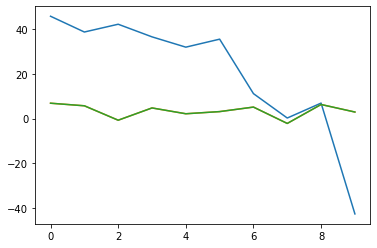

In [30]:
window = 0.5
window_ind = 2001
eeg_ind = 1
plt.plot(true_vals[window][window_ind], label='predicted')
plt.plot(all_eeg[int((window_ind+1)*window/dt):int((window_ind+1)*window/dt) + T_pred, eeg_ind], label='true')
plt.show()

# Plot Windows

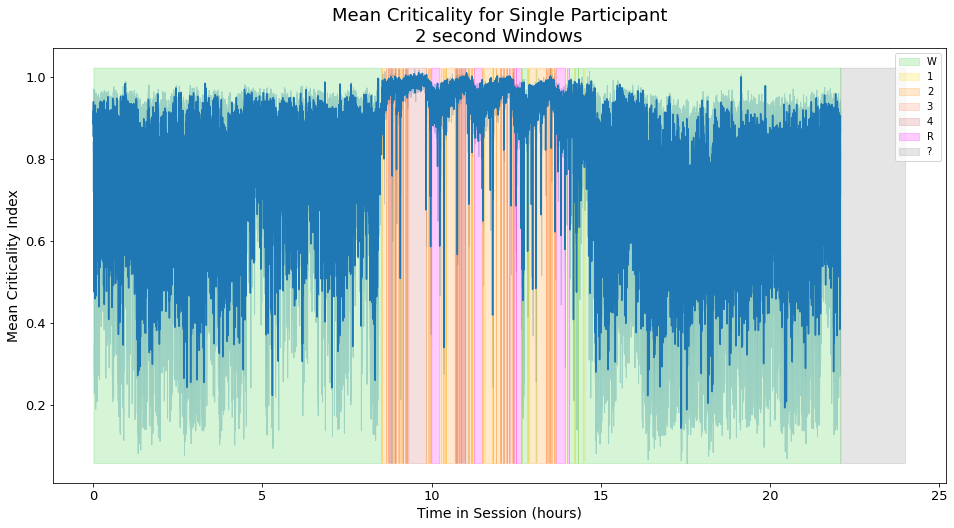

In [42]:
colors = {'W': 'limegreen', '1': 'gold', '2': 'darkorange', '3': 'coral', '4': 'indianred', 'R': 'magenta', '?': 'gray', 'e': 'gray'}

plt.figure(figsize=(16, 8))
time_vals = VAR_results[selected_windows].start_time/3600
# plt.plot(time_vals, eeg_df['EEG Fpz-Cz'])
# plt.plot(time_vals, eeg_df['EEG Pz-Oz'])
criticality_inds = VAR_results[selected_windows].criticality_inds.apply(lambda x: x.mean())
std_errors = VAR_results[selected_windows].criticality_inds.apply(lambda x: x.std()/np.sqrt(len(x)))
plt.plot(time_vals, criticality_inds)
plt.fill_between(time_vals, criticality_inds - std_errors, criticality_inds + std_errors, alpha=0.3, color='C0')
min_val = (criticality_inds - std_errors).min()
max_val = (criticality_inds + std_errors).max()
place_in_session = 0

seen = {}
for stage in colors.keys():
    seen[stage] = False
for _, row in hypnogram_df.iterrows():
    plt.fill_between(np.arange(row.start_time, row.end_time)/3600, min_val, max_val, color=colors[row.sleep_stage], label=row.sleep_stage if not seen[row.sleep_stage] else "", alpha=0.2)
    seen[row.sleep_stage] = True
plt.xlabel("Time in Session (hours)", fontsize=14)
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality for Single Participant\n{selected_windows} second Windows", fontsize=18)
# plt.xlim([9, 10])
plt.legend()
plt.show()

In [35]:
VAR_results[selected_windows]['sleep_stage'] = [None]*len(VAR_results[selected_windows])
for i, row in tqdm(VAR_results[selected_windows].iterrows(), total=len(VAR_results[selected_windows])):
    sleep_stage_counts = {'W': 0, '1': 0, '2': 0, '3': 0, '4': 0, 'R': 0, '?': 0, 'e': 0}
    
    start_time_bool = hypnogram_df.start_time <= row.start_time
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(hypnogram_df) else len(hypnogram_df) - 1
    end_time_bool = hypnogram_df.end_time > row.end_time
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(hypnogram_df) - 1
    
    for row_ind in range(start_row, end_row + 1):
        row2 = hypnogram_df.iloc[row_ind]
        
        if row2.start_time <= row.start_time:
            start_in_chunk = row.start_time - row2.start_time
        else:
            start_in_chunk = 0
        
        if row2.end_time <= row.end_time:
            end_in_chunk = row2.duration
        else:
            end_in_chunk = row.end_time - row2.start_time
        
        sleep_stage_counts[row2.sleep_stage] += end_in_chunk - start_in_chunk
            
    VAR_results[selected_windows].loc[i, 'sleep_stage'] = max(sleep_stage_counts, key=sleep_stage_counts.get)

  0%|          | 0/39750 [00:00<?, ?it/s]

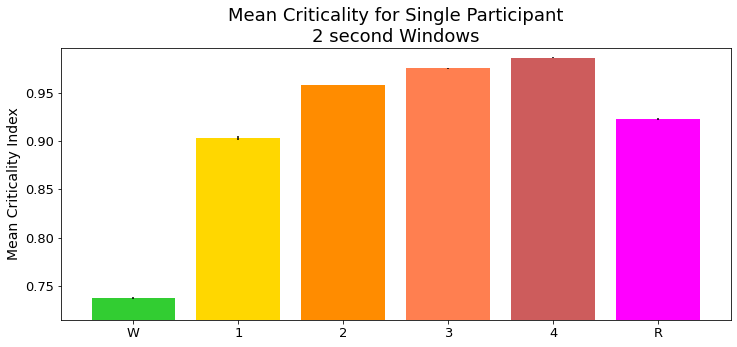

In [37]:
plt.figure(figsize=(12, 5))
mean_criticality_sleep_stage = []
std_error_sleep_stage = []
sleep_stage = []
sleep_stage_colors = []
for s in colors.keys():
    if s != '?' and s != 'e':
        if np.sum(VAR_results[selected_windows].sleep_stage == s) > 0:
            sleep_stage.append(s)
            all_inds = np.vstack(VAR_results[selected_windows][VAR_results[selected_windows].sleep_stage == s].criticality_inds.to_numpy()).flatten()
            mean_criticality_sleep_stage.append(all_inds.mean())
            std_error_sleep_stage.append(all_inds.std()/np.sqrt(len(all_inds)))
            sleep_stage_colors.append(colors[s])

plt.bar(sleep_stage, mean_criticality_sleep_stage, yerr=std_error_sleep_stage, color=sleep_stage_colors)
plt.ylim([np.min(mean_criticality_sleep_stage)*0.97, np.max(mean_criticality_sleep_stage)*1.01])
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality for Single Participant\n{selected_windows} second Windows", fontsize=18)
plt.show()